In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import torchvision
import torch
import tvm
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from tvm import relax
import IPython

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


训练一个小模型

In [2]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear0 = torch.nn.Linear(784, 128)
        self.linear1 = torch.nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.linear0(x)
        x = torch.nn.functional.relu(x)
        x = self.linear1(x)
        return x
        
m = Model()
m.cuda()

criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(m.parameters(), lr=0.001, momentum=0.95)

train_data = torchvision.datasets.FashionMNIST(root='data', train=True, download=True,
                                               transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

for epoch in range(5):
    for img, lbl in train_loader:
        opt.zero_grad()
        
        img = img.reshape(-1, 784).cuda()
        pred = m(img)
        lbl = lbl.cuda()
        
        loss = criterion(pred, lbl)
        loss.backward()
        opt.step()
        
w0 = m.linear0.weight.data.cpu().numpy()
b0 = m.linear0.bias.data.cpu().numpy()
w1 = m.linear1.weight.data.cpu().numpy()
b1 = m.linear1.bias.data.cpu().numpy()

data = {
    "w0": w0,
    "b0": b0,
    "w1": w1,
    "b1": b1
}

with open("fasionmnist_mlp_params.pkl", 'wb') as f:
    pkl.dump(data, f)

In [3]:
with open("fasionmnist_mlp_params.pkl", "rb") as f:
    data = pkl.load(f)
    
w0 = data['w0']
b0 = data['b0']
w1 = data['w1']
b1 = data['b1']

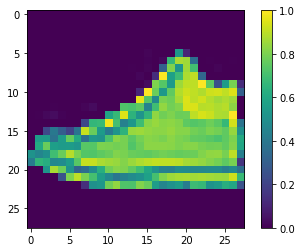

Class:  Ankle boot


In [4]:
test_data = torchvision.datasets.FashionMNIST(root='data', train=False, download=True,
                                              transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, lbl = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print('Class: ', class_names[lbl[0]])

In [5]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

r = numpy_mlp(img[0].reshape(1, -1), w0, b0, w1, b1)
print(class_names[np.argmax(r)])

Sneaker


low level numpy

In [6]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
                
    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]
            
def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
    for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)
            
def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
                
    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]
            

def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)
    
    relu0 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, relu0)
    
    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(relu0, w1, b1, out)
    return out
    

r = lnumpy_mlp(img[0].reshape(1, -1), w0, b0, w1, b1)
print(class_names[np.argmax(r)])

Sneaker


IRModule

In [7]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), "float32"))
            lv1 = R.call_tir(relu0, (lv0,), relax.TensorStructInfo((1, 128), "float32"))
            out = R.call_tir(linear1, (lv1, w1, b1), relax.TensorStructInfo((1, 10), "float32"))
            R.output(out)
        return out

In [8]:
IPython.display.Code(MyModule.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"], Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "relu0"})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out
        
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"], W: T.Buffer[(10, 128), "float32"], B: T.Buffer[10, "float32"], Z: T.Buffer[(1, 10), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear1"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

In [9]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {
    "w0": tvm.nd.array(w0),
    "b0": tvm.nd.array(b0),
    "w1": tvm.nd.array(w1),
    "b1": tvm.nd.array(b1)
}

In [10]:
ex = relax.vm.build(MyModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
nd_res = vm["main"](data_nd, nd_params['w0'], nd_params['b0'], nd_params['w1'], nd_params['b1'])

print(nd_res)
print(class_names[np.argmax(nd_res.numpy(), axis=1)[0]])

[[-4.704714  -7.1897197 -4.302327  -5.0276804 -4.877816   6.142071
  -3.6109517 10.798026   4.48125    9.493341 ]]
Sneaker


env prim_func

In [11]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), relax.TensorStructInfo((1, 128), "float32"))
            lv1 = R.call_tir("env.relu", (lv0,), relax.TensorStructInfo((1, 128), "float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), relax.TensorStructInfo((1, 10), "float32"))
            R.output(out)
        return out

In [12]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)
    
@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)
    

In [13]:
IPython.display.Code(MyModuleWithExternCall.script(), language="python")

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [14]:
ex = relax.vm.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd, nd_params['w0'], nd_params['b0'], nd_params['w1'], nd_params['b1'])
print(nd_res)
print(class_names[np.argmax(nd_res.numpy(), axis=1)[0]])

[[-4.7047157 -7.189722  -4.302327  -5.027681  -4.8778167  6.14207
  -3.610952  10.798028   4.4812484  9.493342 ]]
Sneaker


bind params

In [15]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleWithExternCall)
IPython.display.Code(MyModuleWithParams.script(), language="python")

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [16]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)
print(nd_res)
print(class_names[np.argmax(nd_res.numpy(), axis=1)[0]])

[[-4.7047157 -7.189722  -4.302327  -5.027681  -4.8778167  6.14207
  -3.610952  10.798028   4.4812484  9.493342 ]]
Sneaker


In [17]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
                
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]
                
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), "float32"))
            lv1 = R.call_tir("env.relu", (lv0,), relax.TensorStructInfo((1, 128), "float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), relax.TensorStructInfo((1, 10), "float32"))
            R.output(out)
        return out
    
IPython.display.Code(MyModuleMixture.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [18]:
ex = relax.vm.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd, nd_params['w0'], nd_params['b0'], nd_params['w1'], nd_params['b1'])
print(nd_res)
print(class_names[np.argmax(nd_res.numpy(), axis=1)[0]])

[[-4.704714  -7.1897206 -4.302327  -5.027681  -4.877816   6.142069
  -3.6109524 10.798026   4.4812484  9.4933405]]
Sneaker
